In [1]:
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
import tensorflow as tf
from functools import partial

Welcome to JupyROOT 6.10/08


In [2]:
n_particles = 10000/2
p = np.random.uniform(0.3,10.,n_particles)
mp = np.random.uniform(1/10.,1/0.3,n_particles)
p_mp = 1./mp 

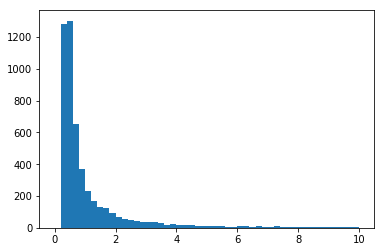

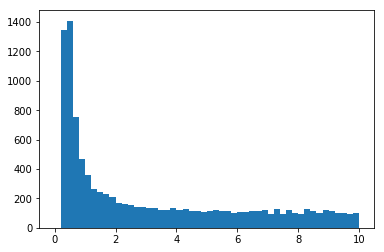

In [3]:
plt.hist(p_mp,50,range=(0.,10.))
plt.show()
p_ges = np.concatenate([p,p_mp])
plt.hist(p_ges,50,range=(0,10))
plt.show()

In [4]:
mass_pi = 0.139
mass_mu = 0.105
mass_e = 0.000511
mass_p = 0.938
mass_K = 0.494
masses = [mass_pi, mass_mu, mass_e, mass_p, mass_K]
masses

[0.139, 0.105, 0.000511, 0.938, 0.494]

In [5]:
signals = []
for mass in masses:
    ITS_tmp = []
    TPCROC0_tmp = []
    TPCROC1_tmp = []
    TPCROC2_tmp = []
    TRD_tmp = []
    TOF_tmp = []
    for p in p_ges:
        bg = p/mass
        beta = bg/math.sqrt(1.+ bg*bg);
        BBS = ROOT.AliExternalTrackParam.BetheBlochSolid(bg)
        BBA = ROOT.AliExternalTrackParam.BetheBlochAleph(bg)
        ITS_tmp.append(np.random.normal(BBS,0.1*BBS) ) ## ITS dEdx = smeared gaus 10% 
        TPCROC0_tmp.append(np.random.normal(BBA,0.1*BBA) )## TPC dEdx = smeared gaus 10% for 1st layer
        TPCROC1_tmp.append(np.random.normal(BBA,0.1*BBA) )  ## TPC dEdx = smeared gaus 10% for 2nd layer
        TPCROC2_tmp.append(np.random.normal(BBA,0.1*BBA) )  ## TPC dEdx = smeared gaus 10% for 3d layer
        TRD_tmp.append(np.random.normal(BBA,0.1*BBA) )  ## TRD dEdx = smeared gaus 10% 
        TOF_tmp.append(np.random.normal(beta,0.1*beta) )  ## TOF - smeared with .... gaussian
    signals.append({'ITS': ITS_tmp, 'TPCROC0': TPCROC0_tmp, 'TPCROC1': TPCROC1_tmp, 'TPCROC1': TPCROC1_tmp, 
                    'TPCROC2': TPCROC2_tmp, 'TRD': TRD_tmp, 'TOF': TOF_tmp})

[]

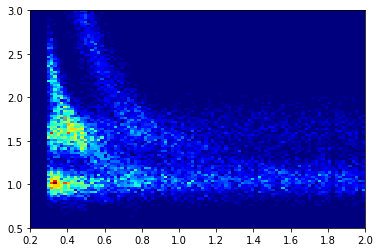

In [6]:
df_list=[]
for i, val in enumerate(masses):
    df = pd.DataFrame.from_dict(signals[i])
    df['p'] = pd.Series(p_ges, index=df.index)
    df['particle'] = pd.Series(i, index=df.index)
    df_list.append(df)
df_all = pd.concat([df_list[0],df_list[2],df_list[3],df_list[4]], ignore_index=True)
plt.hist2d(df_all["p"], df_all["TPCROC1"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0.5, 3]])
plt.plot()

In [7]:
N=len(df_all)
probabilty = 0.95

flips_raw = (1*(np.random.random(size=6*N)<probabilty)).reshape(6,-1)

flips=flips_raw[0]
for i in range(1,6):
    # (1<<i = 2**i)
    flips=flips_raw[i]*(1<<i) + flips


df_all.loc[:,'flips']=flips
df_all.head(5)

,ITS,TOF,TPCROC0,TPCROC1,TPCROC2,TRD,p,particle,flips
0,0.001876,1.118382,1.400154,1.283007,1.286354,1.476715,6.960797,0,63
1,0.002161,0.834615,1.298617,1.064123,1.317187,1.323193,6.061898,0,63
2,0.001974,1.019529,1.222457,1.190231,1.085385,1.193840,2.993727,0,63
3,0.001886,0.971169,0.815833,1.013392,1.046606,1.030747,1.081588,0,57
4,0.001781,1.110512,1.217670,1.397451,1.321348,1.328026,4.374931,0,63


In [8]:
# prepare "flips-Data" and weights
for i ,name in enumerate(['ITS','TOF','TPCROC0','TPCROC1','TPCROC2','TRD']):
    # calculate "flip= 0/1"
    f=(np.array(df_all['flips'])>>i)&1
    # if f=0 substitute value by mean
    m=df_all[name].mean()
    df_all.loc[:,name+'_mr']= df_all[name].multiply(f,axis='index')+m*(1-f) #mean replaced
    df_all.loc[:,name+'_w']=1.0*f #weight
    df_all.loc[:,name+'_0']= df_all[name].multiply(f,axis='index') #zeros
    
# generate data for stage 2
df_stage_2=df_all.copy()
df_stage_3=df_all.copy()
df_all[df_all['particle']==0].head(10)

,ITS,TOF,TPCROC0,TPCROC1,TPCROC2,TRD,p,particle,flips,ITS_mr,...,TPCROC0_0,TPCROC1_mr,TPCROC1_w,TPCROC1_0,TPCROC2_mr,TPCROC2_w,TPCROC2_0,TRD_mr,TRD_w,TRD_0
0,0.001876,1.118382,1.400154,1.283007,1.286354,1.476715,6.960797,0,63,0.001876,...,1.400154,1.283007,1.0,1.283007,1.286354,1.0,1.286354,1.476715,1.0,1.476715
1,0.002161,0.834615,1.298617,1.064123,1.317187,1.323193,6.061898,0,63,0.002161,...,1.298617,1.064123,1.0,1.064123,1.317187,1.0,1.317187,1.323193,1.0,1.323193
2,0.001974,1.019529,1.222457,1.190231,1.085385,1.193840,2.993727,0,63,0.001974,...,1.222457,1.190231,1.0,1.190231,1.085385,1.0,1.085385,1.193840,1.0,1.193840
3,0.001886,0.971169,0.815833,1.013392,1.046606,1.030747,1.081588,0,57,0.001886,...,0.000000,1.013392,1.0,1.013392,1.046606,1.0,1.046606,1.030747,1.0,1.030747
4,0.001781,1.110512,1.217670,1.397451,1.321348,1.328026,4.374931,0,63,0.001781,...,1.217670,1.397451,1.0,1.397451,1.321348,1.0,1.321348,1.328026,1.0,1.328026
5,0.001983,0.976142,1.151044,1.165133,1.166762,1.110739,2.203330,0,63,0.001983,...,1.151044,1.165133,1.0,1.165133,1.166762,1.0,1.166762,1.110739,1.0,1.110739
6,0.002176,0.838962,1.191545,1.062937,1.672534,1.026063,8.296247,0,63,0.002176,...,1.191545,1.062937,1.0,1.062937,1.672534,1.0,1.672534,1.026063,1.0,1.026063
7,0.002134,0.960046,1.427616,1.309126,1.450852,1.389302,7.202524,0,63,0.002134,...,1.427616,1.309126,1.0,1.309126,1.450852,1.0,1.450852,1.389302,1.0,1.389302
8,0.001938,1.051485,1.208800,1.376441,1.202279,1.345475,5.527327,0,63,0.001938,...,1.208800,1.376441,1.0,1.376441,1.202279,1.0,1.202279,1.345475,1.0,1.345475
9,0.002201,0.990256,1.285685,1.400345,1.187124,1.271107,8.326023,0,63,0.002201,...,1.285685,1.400345,1.0,1.400345,1.187124,1.0,1.187124,1.271107,1.0,1.271107


In [9]:
train, test =train_test_split(df_all, test_size=0.5)

# Create autoencoders

In [10]:
def custom_loss(y_true, y_pred,weights):
    return K.mean(K.square((y_true - y_pred)*weights))

inputs = Input(shape=(6,))
inputw = Input(shape=(6,))
enc1   = Dense(units=64, activation='selu')(inputs)
enc2   = Dense(units=64, activation='selu')(enc1)
enc3   = Dense(units=64, activation='selu')(enc2)
enc4   = Dense(units=64, activation='selu')(enc3)
layer0 = Dense(units=2 , activation='linear',activity_regularizer=regularizers.l1(10e-4))(enc4)
dec1   = Dense(units=64, activation='selu')(layer0)
dec2   = Dense(units=64, activation='selu')(dec1)
dec3   = Dense(units=64, activation='selu')(dec2)
dec4   = Dense(units=64, activation='selu')(dec3)
outputs= Dense(units=6, activation='linear')(dec4)

c_loss = partial(custom_loss, weights=inputw)
        
modelpt = Model(inputs=inputs,outputs=outputs)
models2 = Model(inputs=inputs,outputs=outputs)
modell = Model(inputs=inputs,outputs=outputs)
model0 = Model(inputs=inputs,outputs=outputs)
model1 = Model(inputs=[inputs,inputw],outputs=outputs)
modelpt.compile(loss='mse',
              optimizer='adam',
              metrics=['mse'])
models2.compile(loss='mse',
              optimizer='adam',
              metrics=['mse'])
modell.compile(loss='mse',
              optimizer='adam',
              metrics=['mse'])
model0.compile(loss='mse',
              optimizer='adam',
              metrics=['mse'])
model1.compile(loss=c_loss,
              optimizer='adam',
              metrics=['mse'])

In [11]:
model0.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 6)                 0         
_________________________________________________________________
dense (Dense)                (None, 64)                448       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 130       
_________________________________________________________________
dense_5 (Dense)              (None, 64)                192       
__________

# perfect tracks

In [12]:
train_pt = train[["ITS", "TOF", "TPCROC0", "TPCROC1", "TPCROC2", "TRD"]]
test_pt = test[["ITS", "TOF", "TPCROC0", "TPCROC1", "TPCROC2", "TRD"]]
scaler_pt = StandardScaler()
scaler_pt.fit( train[["ITS", "TOF", "TPCROC0", "TPCROC1", "TPCROC2", "TRD"]])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [13]:
modelpt.fit(scaler_pt.transform(train_pt), scaler_pt.transform(train_pt), epochs=5, batch_size=32, 
          validation_data=[scaler_pt.transform(test_pt),scaler_pt.transform(test_pt)])

Train on 20000 samples, validate on 20000 samples
Epoch 1/5
20000/20000 [==============================] - 7s 333us/step - loss: 0.1454 - mean_squared_error: 0.0810 - val_loss: 0.1116 - val_mean_squared_error: 0.0643
Epoch 2/5
20000/20000 [==============================] - 5s 265us/step - loss: 0.0931 - mean_squared_error: 0.0543 - val_loss: 0.1026 - val_mean_squared_error: 0.0595
Epoch 3/5
20000/20000 [==============================] - 5s 265us/step - loss: 0.0829 - mean_squared_error: 0.0506 - val_loss: 0.0771 - val_mean_squared_error: 0.0506
Epoch 4/5
20000/20000 [==============================] - 5s 264us/step - loss: 0.0739 - mean_squared_error: 0.0473 - val_loss: 0.0682 - val_mean_squared_error: 0.0430
Epoch 5/5
20000/20000 [==============================] - 5s 268us/step - loss: 0.0700 - mean_squared_error: 0.0458 - val_loss: 0.0705 - val_mean_squared_error: 0.0491


2019-01-29 15:46:42.259846: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: FMA


In [14]:
out = scaler_pt.inverse_transform(modelpt.predict(scaler_pt.transform(test_pt)))
AE_predict = pd.DataFrame(out)
AE_predict.columns = ["ITS_ae", "TOF_ae", "TPCROC0_ae", "TPCROC1_ae", "TPCROC2_ae", "TRD_ae"]
test = test.reset_index()
df_test = pd.concat([test,AE_predict], axis = 1)
df_test.head(3)

,index,ITS,TOF,TPCROC0,TPCROC1,TPCROC2,TRD,p,particle,flips,...,TPCROC2_0,TRD_mr,TRD_w,TRD_0,ITS_ae,TOF_ae,TPCROC0_ae,TPCROC1_ae,TPCROC2_ae,TRD_ae
0,24046,0.002058,0.931931,1.082367,1.116329,1.173777,1.066094,6.601343,3,61,...,1.173777,1.066094,1.0,1.066094,0.001805,0.968895,1.108639,1.143062,1.107739,1.094225
1,13828,0.002422,0.940766,1.433450,1.566123,1.770192,1.507235,5.817805,2,61,...,1.770192,1.507235,1.0,1.507235,0.002532,0.978720,1.501819,1.523969,1.500517,1.487708
2,20188,0.001701,1.116355,1.083332,1.172431,0.855223,1.043763,7.041901,3,31,...,0.855223,1.485453,0.0,0.000000,0.001883,1.141884,1.150535,1.205595,1.158487,1.146943


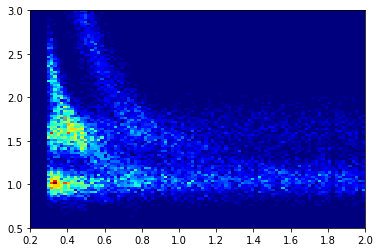

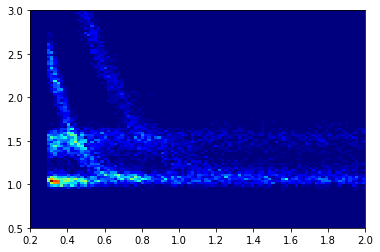

In [15]:
plt.hist2d(df_all["p"], df_all["TPCROC1"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0.5, 3]])
plt.show()
plt.hist2d(df_test["p"], df_test["TPCROC2_ae"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0.5, 3]])
plt.show()

# Train with zeros

In [16]:
train_0 = train[["ITS_0", "TOF_0", "TPCROC0_0", "TPCROC1_0", "TPCROC2_0", "TRD_0"]]
test_0 = test[["ITS_0", "TOF_0", "TPCROC0_0", "TPCROC1_0", "TPCROC2_0", "TRD_0"]]
scaler_0 = StandardScaler()
scaler_0.fit( train[["ITS_0", "TOF_0", "TPCROC0_0", "TPCROC1_0", "TPCROC2_0", "TRD_0"]])
#scaler_0.fit( train[["ITS", "TOF", "TPCROC0", "TPCROC1", "TPCROC2", "TRD"]]) 

StandardScaler(copy=True, with_mean=True, with_std=True)

In [17]:
train[["ITS_0", "TOF_0", "TPCROC0_0", "TPCROC1_0", "TPCROC2_0", "TRD_0"]].head()

,ITS_0,TOF_0,TPCROC0_0,TPCROC1_0,TPCROC2_0,TRD_0
17190,0.002842,0.882161,1.530464,1.360363,1.681578,1.529194
33062,0.001786,1.147631,1.001753,1.239490,1.115969,1.109676
21101,0.001421,0.999654,1.054486,1.149225,0.992124,0.000000
17660,0.002982,0.929222,1.583967,1.641427,1.448455,1.704423
26304,0.010295,0.298979,5.890153,5.277499,5.397682,5.330434


In [18]:
train[["ITS", "TOF", "TPCROC0", "TPCROC1", "TPCROC2", "TRD"]].head()


,ITS,TOF,TPCROC0,TPCROC1,TPCROC2,TRD
17190,0.002842,0.882161,1.530464,1.360363,1.681578,1.529194
33062,0.001786,1.147631,1.001753,1.239490,1.115969,1.109676
21101,0.001421,0.999654,1.054486,1.149225,0.992124,0.830137
17660,0.002982,0.929222,1.583967,1.641427,1.448455,1.704423
26304,0.010295,0.298979,5.890153,5.277499,5.397682,5.330434


In [19]:
model0.fit(scaler_0.transform(train_0), scaler_0.transform(train_0), epochs=5, batch_size=32, 
          validation_data=[scaler_0.transform(test_0),scaler_0.transform(test_0)])

Train on 20000 samples, validate on 20000 samples
Epoch 1/5
20000/20000 [==============================] - 7s 340us/step - loss: 0.2002 - mean_squared_error: 0.1715 - val_loss: 0.1819 - val_mean_squared_error: 0.1579
Epoch 2/5
20000/20000 [==============================] - 5s 272us/step - loss: 0.1889 - mean_squared_error: 0.1630 - val_loss: 0.1913 - val_mean_squared_error: 0.1703
Epoch 3/5
20000/20000 [==============================] - 5s 268us/step - loss: 0.1814 - mean_squared_error: 0.1592 - val_loss: 0.1893 - val_mean_squared_error: 0.1672
Epoch 4/5
20000/20000 [==============================] - 5s 269us/step - loss: 0.1766 - mean_squared_error: 0.1539 - val_loss: 0.1632 - val_mean_squared_error: 0.1432
Epoch 5/5
20000/20000 [==============================] - 5s 271us/step - loss: 0.1609 - mean_squared_error: 0.1407 - val_loss: 0.1683 - val_mean_squared_error: 0.1493


In [20]:
out = scaler_0.inverse_transform(model0.predict(scaler_0.transform(test_0)))
AE_predict = pd.DataFrame(out)
AE_predict.columns = ["ITS_ae", "TOF_ae", "TPCROC0_ae", "TPCROC1_ae", "TPCROC2_ae", "TRD_ae"]
test = test.reset_index()
df_test = pd.concat([test,AE_predict], axis = 1)
df_test.head(3)

,level_0,index,ITS,TOF,TPCROC0,TPCROC1,TPCROC2,TRD,p,particle,...,TPCROC2_0,TRD_mr,TRD_w,TRD_0,ITS_ae,TOF_ae,TPCROC0_ae,TPCROC1_ae,TPCROC2_ae,TRD_ae
0,0,24046,0.002058,0.931931,1.082367,1.116329,1.173777,1.066094,6.601343,3,...,1.173777,1.066094,1.0,1.066094,0.001814,-0.062470,1.107289,1.121171,1.171285,1.240546
1,1,13828,0.002422,0.940766,1.433450,1.566123,1.770192,1.507235,5.817805,2,...,1.770192,1.507235,1.0,1.507235,0.002738,0.038708,1.561486,1.506964,1.590468,1.654390
2,2,20188,0.001701,1.116355,1.083332,1.172431,0.855223,1.043763,7.041901,3,...,0.855223,1.485453,0.0,0.000000,0.001566,1.003015,0.871500,0.875508,0.797705,0.851782


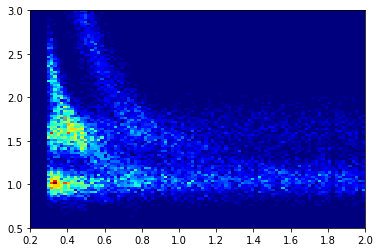

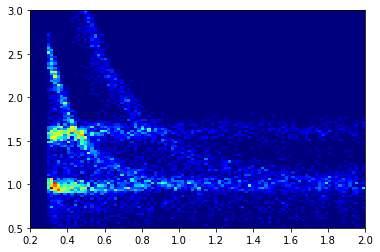

In [21]:
plt.hist2d(df_all["p"], df_all["TPCROC1"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0.5, 3]])
plt.show()
plt.hist2d(df_test["p"], df_test["TPCROC2_ae"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0.5, 3]])
plt.show()

# labels for missing tracks

In [22]:
train_in = train[["ITS_mr", "TOF_mr", "TPCROC0_mr", "TPCROC1_mr", "TPCROC2_mr", "TRD_mr"]]
train_out = train[["ITS", "TOF", "TPCROC0", "TPCROC1", "TPCROC2", "TRD"]]
test_in = test[["ITS_mr", "TOF_mr", "TPCROC0_mr", "TPCROC1_mr", "TPCROC2_mr", "TRD_mr"]]
test_out = test[["ITS", "TOF", "TPCROC0", "TPCROC1", "TPCROC2", "TRD"]]
scaler_in = StandardScaler()
scaler_out = StandardScaler()
scaler_in.fit(train_in)
scaler_out.fit(train_out)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [23]:
modell.fit(scaler_in.transform(train_in), scaler_out.transform(train_out), epochs=5, batch_size=32, 
          validation_data=[scaler_in.transform(test_in),scaler_out.transform(test_out)])

Train on 20000 samples, validate on 20000 samples
Epoch 1/5
19872/20000 [============================>.] - ETA: 0s - loss: 0.0697 - mean_squared_error: 0.0531

KeyboardInterrupt: 

In [ ]:
out = scaler_out.inverse_transform(modell.predict(scaler_in.transform(test_in)))
AE_predict = pd.DataFrame(out)
AE_predict.columns = ["ITS_ae", "TOF_ae", "TPCROC0_ae", "TPCROC1_ae", "TPCROC2_ae", "TRD_ae"]
#test = test.reset_index()
df_test = pd.concat([test,AE_predict], axis = 1)
df_test.head(3)

In [ ]:
plt.hist2d(df_all["p"], df_all["TPCROC1"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0.5, 3]])
plt.show()
plt.hist2d(df_test["p"], df_test["TPCROC1_ae"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0.5, 3]])
plt.show()

# mean input, zero weights for missing values

In [ ]:
train_mr = train[["ITS_mr", "TOF_mr", "TPCROC0_mr", "TPCROC1_mr", "TPCROC2_mr", "TRD_mr"]]
test_mr = test[["ITS_mr", "TOF_mr", "TPCROC0_mr", "TPCROC1_mr", "TPCROC2_mr", "TRD_mr"]]
train_w    = train[["ITS_w", "TOF_w", "TPCROC0_w", "TPCROC1_w", "TPCROC2_w", "TRD_w"]]
test_w     = test[["ITS_w", "TOF_w", "TPCROC0_w", "TPCROC1_w", "TPCROC2_w", "TRD_w"]]

In [ ]:
scaler_mr = StandardScaler()
scaler_mr.fit(train_mr)

In [ ]:
model1.fit([scaler_mr.transform(train_mr),train_w], scaler_mr.transform(train_mr), epochs=5, batch_size=32, 
          validation_data=[[scaler_mr.transform(test_mr),train_w],scaler_mr.transform(test_mr)])

In [ ]:
out = scaler_mr.inverse_transform(model1.predict([scaler_mr.transform(test_mr),test_w]))
AE_predict = pd.DataFrame(out)
AE_predict.columns = ["ITS_ae", "TOF_ae", "TPCROC0_ae", "TPCROC1_ae", "TPCROC2_ae", "TRD_ae"]
#test = test.reset_index()
df_test = pd.concat([test,AE_predict], axis = 1)
df_test.head(3)

In [ ]:
plt.hist2d(df_all["p"], df_all["TPCROC1"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0.5, 3]])
plt.show()
plt.hist2d(df_test["p"], df_test["TPCROC1_ae"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0.5, 3]])
plt.show()

# second iteration, replace missing values by values from first iteration

In [ ]:
# stage 2
stage2_data = df_stage_2[["ITS_mr", "TOF_mr", "TPCROC0_mr", "TPCROC1_mr", "TPCROC2_mr", "TRD_mr"]]
out = scaler_mr.inverse_transform(models2.predict(scaler_mr.transform(stage2_data)))
AE_predict = pd.DataFrame(out)
AE_predict.columns = ["ITS_ae", "TOF_ae", "TPCROC0_ae", "TPCROC1_ae", "TPCROC2_ae", "TRD_ae"]
for i ,name in enumerate(['ITS','TOF','TPCROC0','TPCROC1','TPCROC2','TRD']):
    # calculate "flip= 0/1"
    f=(np.array(df_stage_2['flips'])>>i)&1
    m=AE_predict[name+'_ae']
    df_stage_2.loc[:,name+'_s2']= df_stage_2[name].multiply(f,axis='index')+m*(1-f)

In [ ]:
train, test =train_test_split(df_stage_2, test_size=0.5)
train_s2 = train[["ITS_s2", "TOF_s2", "TPCROC0_s2", "TPCROC1_s2", "TPCROC2_s2", "TRD_s2"]]
test_s2 = test[["ITS_s2", "TOF_s2", "TPCROC0_s2", "TPCROC1_s2", "TPCROC2_s2", "TRD_s2"]]

In [ ]:
scaler_s2 = StandardScaler()
scaler_s2.fit(train_s2)
models2.fit(scaler_s2.transform(train_s2), scaler_s2.transform(train_s2), epochs=5, batch_size=32, 
          validation_data=[scaler_s2.transform(test_s2),scaler_s2.transform(test_s2)])

In [ ]:
out = scaler_s2.inverse_transform(models2.predict(scaler_s2.transform(test_s2)))
AE_predict = pd.DataFrame(out)
AE_predict.columns = ["ITS_ae", "TOF_ae", "TPCROC0_ae", "TPCROC1_ae", "TPCROC2_ae", "TRD_ae"]
test = test.reset_index()
df_test = pd.concat([test,AE_predict], axis = 1)
df_test.head(3)

In [ ]:
plt.hist2d(df_all["p"], df_all["TPCROC1"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0.5, 3]])
plt.show()
plt.hist2d(df_test["p"], df_test["TPCROC1_ae"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0.5, 3]])
plt.show()